### This notebook aims to show what the script main.jl does

In [1]:
#Useful code and packages
include("../scripts/oggm_access.jl")
include("../scripts/1D_SIA.jl")
include("../scripts/1D_SIA_raw.jl")
using NCDatasets
using BenchmarkTools
using Distributed
using Plots

2023-05-11 15:58:56: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-05-11 15:58:56: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-05-11 15:58:56: oggm.cfg: Multiprocessing: using all available processors (N=16)
2023-05-11 15:58:56: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2023-05-11 15:58:56: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2023-05-11 15:58:56: oggm.cfg: PARAMS['store_fl_diagnostics'] changed from `False` to `True`.
2023-05-11 15:58:56: oggm.cfg: Multiprocessing switched ON after user settings.
2023-05-11 15:59:15: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-05-11 15:59:15: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-05-11 15:59:15: oggm.cfg: Multiprocessing: using all available processors (N=16)
2023-05-11 15:59:15: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
202

In [2]:
#Choose one glacier
rgi_ids=["RGI60-11.03638"]
gdirs=init_gdirs(rgi_ids)
gdir=gdirs[1]
gla_name=gdir.name

2023-05-11 15:59:25: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers


"Fr4N01235A08 Dargentiere"

In [3]:
PARAMS["evolution_model"] = "FluxBased"
tasks.init_present_time_glacier(gdir)

#Getting initial parameters from OGGM
fls=gdir.read_pickle("model_flowlines")
bed_o = fls[end].bed_h
surface_o = fls[end].surface_h
widths_o = fls[end].widths_m
dx_o = fls[end].dx_meter


diag = gdir.get_diagnostics()
glen_a_o = diag["inversion_glen_a"]

2023-05-11 16:01:15: oggm.cfg: PARAMS['evolution_model'] changed from `SemiImplicit` to `FluxBased`.


6.079411329372713e-24

In [4]:
#using the solver

iceflow_sol =@btime glacier_evolution(gdir=gdir, 
                                dx=dx_o, # grid resolution in m
                                nx=length(bed_o),  # grid size
                                width=widths_o,  # glacier width in m 
                                glen_a= 2.4e-24,  # Using the standard value of creep parameter
                                n_years=15.0,  # simulation time in years
                                solver = Ralston(),
                                reltol=1e-6,
                                bed_hs=bed_o,
                                surface_ini=surface_o)


#using a numerical scheme ("raw")

xc, bed_h, surface_h, years, volume, long =@btime glacier_evolution_optim(gdir=gdir,
                                                                    dx=dx_o,nx=length(bed_o),
                                                                    width=widths_o,
                                                                    glen_a= 2.4e-14,
                                                                    bed_h=bed_o,
                                                                    surface_ini=surface_o,
                                                                    n_years=15.0)


#Comparing now with oggm

@btime begin 
workflow.execute_entity_task(tasks.run_from_climate_data, gdir,
                    climate_filename="climate_historical",
                    ys=2004, ye=2019,store_fl_diagnostics=true)

end 


  232.967 ms (268150 allocations: 22.93 MiB)
  85.438 ms (77043 allocations: 9.02 MiB)
  121.672 ms (76 allocations: 3.52 KiB)


2023-05-11 16:03:27: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-05-11 16:03:27: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-05-11 16:03:28: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-05-11 16:03:28: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-05-11 16:03:29: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-05-11 16:03:29: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-05-11 16:03:29: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-05-11 16:03:29: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-05-11 16:03:29: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-05-11 16:03:29: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-05-11 16:03:29: oggm.workflow: Execute entity

1-element Vector{PyObject}:
 PyObject <oggm.core.flowline.FluxBasedModel object at 0x7fbc2b466810>

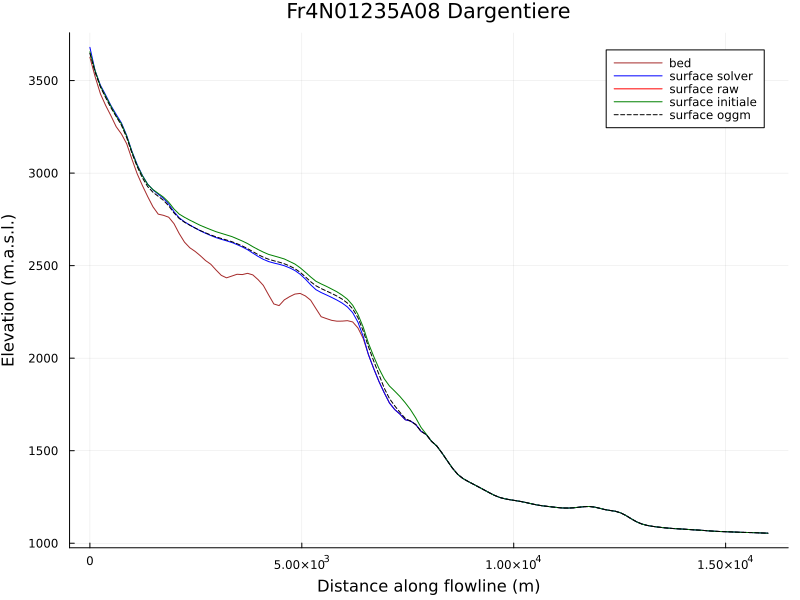

In [8]:
#Plotting everything
begin
    
    plot(xc,bed_o, c="brown",label="bed",title="$gla_name",ylabel="Elevation (m.a.s.l.)",size=(800, 600),
    xlabel="Distance along flowline (m)")
    plot!(xc,iceflow_sol[end] .+ bed_o, c="blue",label="surface solver")
    
    plot!(xc,surface_h, color="red", label="surface raw")
    plot!(xc,surface_o,color="green",label="surface initiale")

    f = gdir.get_filepath("fl_diagnostics")
    ds = NCDataset(f)
    fl_id=0
    ds2=ds.group["fl_$fl_id"]
    plot!(xc,ds2["bed_h"][:,end]+ds2["thickness_m"][:,end],linestyle=:dash,color="black",label="surface oggm")
    

    
    
end 

In [9]:
#when using the calibrated creep parameter A

#using the solver

iceflow_sol =@btime glacier_evolution(gdir=gdir, 
                                dx=dx_o, # grid resolution in m
                                nx=length(bed_o),  # grid size
                                width=widths_o,  # glacier width in m 
                                glen_a= glen_a_o,  # Using the calibrated value of the creep parameter given by OGGM
                                n_years=15.0,  # simulation time in years
                                solver = Ralston(),
                                reltol=1e-6,
                                bed_hs=bed_o,
                                surface_ini=surface_o)


#using a numerical scheme ("raw")

xc, bed_h, surface_h, years, volume, long =@btime glacier_evolution_optim(gdir=gdir,
                                                                    dx=dx_o,nx=length(bed_o),
                                                                    width=widths_o,
                                                                    glen_a= glen_a_o,
                                                                    bed_h=bed_o,
                                                                    surface_ini=surface_o,
                                                                    n_years=15.0)

  796.648 ms (915250 allocations: 78.22 MiB)
  83.610 ms (77043 allocations: 9.02 MiB)


([0.0, 124.0, 248.0, 372.0, 496.0, 620.0, 744.0, 868.0, 992.0, 1116.0  …  14880.0, 15004.0, 15128.0, 15252.0, 15376.0, 15500.0, 15624.0, 15748.0, 15872.0, 15996.0], [3626.0129523802975, 3520.4603781705673, 3428.699836429195, 3365.6462298363367, 3310.125817380288, 3250.823704372064, 3211.521382846077, 3158.6759601048648, 3075.0447485821132, 2996.179750915501  …  1063.2740752060035, 1062.348318114699, 1061.3305960219666, 1060.0456346445815, 1058.9233721453577, 1058.1576419294104, 1057.5034535285276, 1056.6020686887148, 1055.3051669818476, 1054.256454662861], [3673.5006141279027, 3548.3916700624686, 3465.6782495006205, 3412.056587240123, 3353.882943502917, 3305.6289677060076, 3261.036760834966, 3195.4068931497827, 3109.2747922076555, 3036.184371007062  …  1063.2740752060035, 1062.348318114699, 1061.3305960219666, 1060.0456346445815, 1058.9233721453577, 1058.1576419294104, 1057.5034535285276, 1056.6020686887148, 1055.3051669818476, 1054.256454662861], [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.

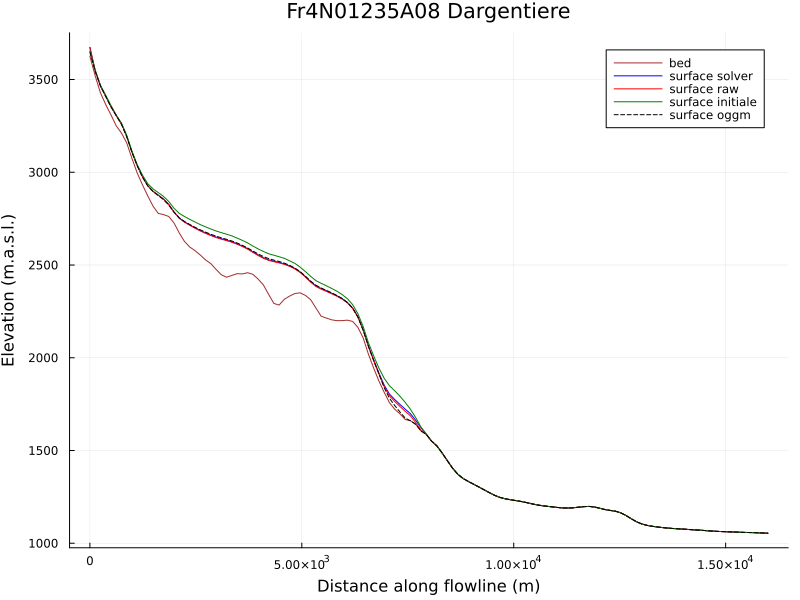

In [10]:
#Plotting everything
begin
    
    plot(xc,bed_o, c="brown",label="bed",title="$gla_name",ylabel="Elevation (m.a.s.l.)",size=(800, 600),
    xlabel="Distance along flowline (m)")
    plot!(xc,iceflow_sol[end] .+ bed_o, c="blue",label="surface solver")
    
    plot!(xc,surface_h, color="red", label="surface raw")
    plot!(xc,surface_o,color="green",label="surface initiale")

    f = gdir.get_filepath("fl_diagnostics")
    ds = NCDataset(f)
    fl_id=0
    ds2=ds.group["fl_$fl_id"]
    plot!(xc,ds2["bed_h"][:,end]+ds2["thickness_m"][:,end],linestyle=:dash,color="black",label="surface oggm")
    

    
    
end 